In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import matplotlib.pyplot as plt

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)  # width, height in inches

# Set default font sizes
plt.rcParams['font.size'] = 15  # Default font size
plt.rcParams['axes.titlesize'] = 15  # Title font size
plt.rcParams['axes.labelsize'] = 15  # Label font size
plt.rcParams['xtick.labelsize'] = 15  # x-axis tick label font size
plt.rcParams['ytick.labelsize'] = 15  # y-axis tick label font size
plt.rcParams['legend.fontsize'] = 15  # Legend font size
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [4]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_continuous_vs_discrete_noavgpopdrift'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [5]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [6]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

# pf_params_all = prepped_data_agg['pf_params_all']
# all_fields_all = prepped_data_agg['all_fields_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 



In [7]:
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

# try change point model on population and visualize

In [680]:
ani,sess=subdb.iloc[0][['animal_name.1','sess_name']]

ti=0,
tt=0
fr_map_trial_df_onett=fr_map_trial_df_all.loc[(ani,sess)].loc[(ti,tt),:]

/tmp/ipykernel_1395310/3138230266.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_df_onett=fr_map_trial_df_all.loc[(ani,sess)].loc[(ti,tt),:]


In [681]:
import ruptures as rpt
from sklearn.decomposition import PCA

In [682]:
xx=fr_map_trial_df_onett.dropna(axis=1,how='all').droplevel((0,1))
zscore_cell = True
std_max=xx.groupby(level=0).apply(lambda x: np.std(x.values)).max()
max_std_sc = 0.1 # adjusted such that more than 1/3 can achieve a var of 1, but others will be scaled
zscore_func = lambda x:(x - np.mean(x.values)) / np.maximum(np.std(x.values),max_std_sc*std_max)
if zscore_cell:
    xx=xx.groupby(level=0).apply(lambda x:zscore_func(x))
xx=xx.dropna(axis=0,how='all')

In [661]:
signal = xx.T.values
n_components = signal.shape[0]-2
pca = PCA(n_components=n_components)
signal=pca.fit_transform(signal)

In [662]:
signal.shape

(12, 10)

In [634]:
pca.explained_variance_ratio_.sum()

0.9562833189856111

In [616]:
# %%time
# ncpts = 2#2000#3
# model = rpt.Dynp(model='l2',jump=1,min_size=2)
# # model = rpt.Dynp(model='l1',jump=1,min_size=2)
# # model = rpt.Dynp(model='normal',jump=1,min_size=2)
# # model = rpt.Dynp(model='cosine',jump=1,min_size=2)
# # model = rpt.Pelt(model='normal',jump=1,min_size=2)
# c=model.fit(signal)
# cpts = model.predict(ncpts)

In [617]:
# c=model.fit(signal)
# cpts = model.predict(ncpts)
# n_trial = signal.shape[0]
# err=c.cost.sum_of_costs(list(cpts))
# err_div_trial=err / n_trial
# sum_of_var = np.var(signal,axis=0).sum()
# r2=(sum_of_var - err_div_trial) / sum_of_var

In [618]:
def fit_cpd_get_r2_multi_d(signal,ncpts, model_type='dyn',cost='l2',min_size=2,jump=1):
    '''
    assuming l2
    '''
    if model_type=='dyn':
        model = rpt.Dynp(model=cost,jump=jump,min_size=min_size)
    c=model.fit(signal)
    cpts = model.predict(ncpts)
    n_trial = signal.shape[0]
    err=c.cost.sum_of_costs(list(cpts))
    err_div_trial=err / n_trial
    sum_of_var = np.var(signal,axis=0).sum()
    r2=(sum_of_var - err_div_trial) / sum_of_var

    return cpts, r2


In [619]:
# ncpts = 1
# cpts, r2 = fit_cpd_get_r2_multi_d(signal,ncpts)

In [620]:
def shuffle_test_cpd_multi_d(signal,ncpts,n_shuffle=500, cpd_kws={}):

    n_trial = signal.shape[0]
    signal_shuffle = [signal[np.random.permutation(n_trial)] for i in range(n_shuffle)]
    
    cpts, r2 = fit_cpd_get_r2_multi_d(signal,ncpts)

    ncpts=1
    r2_sh_l = []
    for signal_sh in signal_shuffle:
        cpts_sh, r2_sh = fit_cpd_get_r2_multi_d(signal_sh,ncpts,**cpd_kws)
        r2_sh_l.append(r2_sh)
    r2_sh_l = np.array(r2_sh_l)
    return r2,cpts, r2_sh_l


0.28148183625477585
[2, 8, 12]


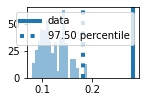

In [663]:
ncpts=2
r2,cpts,r2_sh_l=shuffle_test_cpd_multi_d(signal,ncpts)
ph.plot_shuffle_data_dist_with_thresh(r2_sh_l,r2)
print(r2)
print(cpts)


In [319]:
import umap

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/umap/distances.py:108

In [675]:
signal_reduced.shape

(12, 2)

/tmp/ipykernel_1395310/491837562.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm, ticks=np.arange(0, n_trial+1, 2))


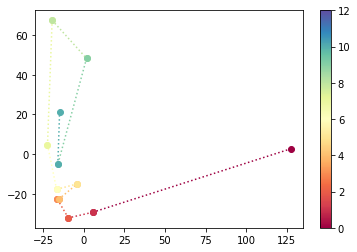

In [679]:
pca = PCA(n_components=2)
# pca = umap.UMAP(n_components=2,n_neighbors=4)
signal_reduced = pca.fit_transform(signal)
n_trial =signal.shape[0]
data =signal_reduced

fig,ax=plt.subplots()
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=n_trial)

for i in range(n_trial-1):
    ax.plot(data[i:i+2, 0], data[i:i+2, 1], linestyle=':', marker='o', color=cmap(norm(i)))

# Adding a colorbar
cm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cm.set_array([])
plt.colorbar(cm, ticks=np.arange(0, n_trial+1, 2))


# ax.plot(signal_reduced[:,0],signal_reduced[:,1],marker='o',linestyle=':')

In [671]:
dim = 2
tcp.test_contiguity(signal[:,dim],n_shuffle=200,n_change_pts=2)

(pval                     0.005000
 exp_var_ratio            0.808031
 exp_var_ratio_sh_med     0.411609
 exp_var_ratio_sh_high    0.665432
 exp_var_ratio_sh_low     0.125593
 dtype: float64,
 array([6062.83382783, 4180.39394362, 5555.67166165, 6095.21349696,
        3739.17691135, 3983.41211959, 5750.61961826, 5566.59395601,
        3820.73772253, 5483.24336979, 7381.04389175, 3769.48211576,
        4804.06434378, 5930.13672258, 3840.73798987, 5181.64428009,
        3738.69904189, 4605.00435779, 4940.59955233, 5150.38838285,
        6453.03736674, 4055.20407334, 5053.91054404, 5133.66572623,
        2894.6317734 , 2889.8343155 , 5606.54934131, 5371.37540617,
        7359.21954402, 4565.43828517, 3171.05645137, 5591.84118526,
        3616.31147302, 4354.5162116 , 7163.82739167, 3987.76955823,
        6860.13213626, 3285.18387452, 4698.54799207, 5403.48815747,
        5005.55181477, 7326.35828459, 5589.30836107, 3594.17128258,
        3405.92804783, 5192.779143  , 6878.99965039, 3645.08

In [672]:
import step_vs_gradual_analysis as svga
svga.fit_poly_regress_get_r2(signal[:,dim],2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                    0.8115
Date:                Tue, 30 Jan 2024   Prob (F-statistic):              0.474
Time:                        20:49:32   Log-Likelihood:                -55.338
No. Observations:                  12   AIC:                             116.7
Df Residuals:                       9   BIC:                             118.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7666     20.789      0.037      0.9

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


(0.1527782493165153,
 array([ 0.76664515, -3.93851497, -7.27394407, -9.23964213, -9.83560917,
        -9.06184518, -6.91835016, -3.40512411,  1.47783297,  7.73052108,
        15.35294021, 24.34509038]))

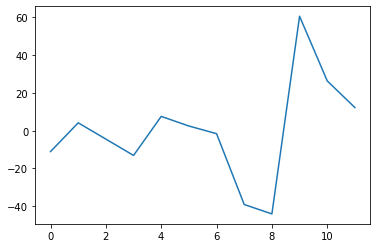

In [673]:
plt.plot(signal[:,dim])

In [653]:
import statsmodels.api as sm
def fit_poly_regress_get_r2(xx,order=1,cost='l2',verbose=True):
    if cost=='l2':
        xs_l = []
        for o in range(1,order+1):
            xs = np.arange(len(xx)) ** o 
            xs_l.append(xs)
        xs_l = np.array(xs_l).T
#         pdb.set_trace()
        xs_l = sm.add_constant(xs_l)
        model = sm.OLS(xx,xs_l)
        results = model.fit()
        if verbose:
            print(results.summary())
        xx_pred=results.predict()
        exp_var=np.var(xx_pred)
        data_var = np.var(xx)
        r2 = results.rsquared
        return r2,xx_pred,exp_var,data_var
            
    else:
        print('not implemented')
        pass

0.28148183625477585
[2, 8, 12]


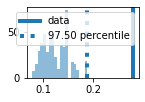

In [668]:
ncpts=2
r2,cpts,r2_sh_l=shuffle_test_cpd_multi_d(signal,ncpts)
ph.plot_shuffle_data_dist_with_thresh(r2_sh_l,r2)
print(r2)
print(cpts)


In [669]:
exp_var_all = []
data_var_all = []
order=ncpts
for ii in range(signal.shape[1]):
    r2,xx_pred,exp_var,data_var = fit_poly_regress_get_r2(signal[:,ii],order=order)
    exp_var_all.append(exp_var)
    data_var_all.append(data_var)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     6.617
Date:                Tue, 30 Jan 2024   Prob (F-statistic):             0.0171
Time:                        20:48:33   Log-Likelihood:                -55.669
No. Observations:                  12   AIC:                             117.3
Df Residuals:                       9   BIC:                             118.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.5656     21.372      3.349      0.0

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/sta

In [670]:
np.sum(exp_var_all) / np.sum(data_var_all)

0.28909346781655115

In [459]:
import statsmodels.api as sm
order=1
xs_l = []
n_trial = signal.shape[0]
for o in range(1,order+1):
    xs = np.arange(n_trial) ** o 
    xs_l.append(xs)
xs_l = np.array(xs_l).T
#         pdb.set_trace()
# xs_l = sm.add_constant(xs_l)

In [458]:
from sklearn.linear_model import LinearRegression

In [461]:
reg_model=LinearRegression()
reg_model.fit(xs_l,signal.T)

LinearRegression()

In [462]:
reg_model.score(xs_l,signal.T)

0.05508769586531785

In [457]:
xs_l

array([[ 1.,  0.],
       [ 1.,  1.],
       [ 1.,  2.],
       [ 1.,  3.],
       [ 1.,  4.],
       [ 1.,  5.],
       [ 1.,  6.],
       [ 1.,  7.],
       [ 1.,  8.],
       [ 1.,  9.],
       [ 1., 10.],
       [ 1., 11.],
       [ 1., 12.],
       [ 1., 13.],
       [ 1., 14.],
       [ 1., 15.],
       [ 1., 16.],
       [ 1., 17.],
       [ 1., 18.],
       [ 1., 19.]])

In [452]:
signal.T

(20, 20)

In [451]:
svga.fit_poly_regress_cpd_get_r2_all(pd.DataFrame(signal).T,2)

,reg,step,step_minus_reg
0,0.940064,0.863131,-0.076934
1,0.458501,0.547495,0.088994
2,0.429873,0.589746,0.159873
3,0.001838,0.345158,0.343320
4,0.063898,0.417329,0.353431
5,0.007955,0.290929,0.282974
6,0.002734,0.191963,0.189230
7,0.036908,0.604939,0.568031
8,0.000455,0.168003,0.167548
9,0.000311,0.398266,0.397954


# simulated examples comparing regression vs change point shuffle test

In [276]:
test_signal=np.exp(np.arange(30)/30) + np.random.normal(size=30) * 0.5
test_signal = test_signal[:,None]

In [277]:
fit_cpd_get_r2_multi_d(test_signal,ncpts)

([10, 30], 0.5220383736489846)

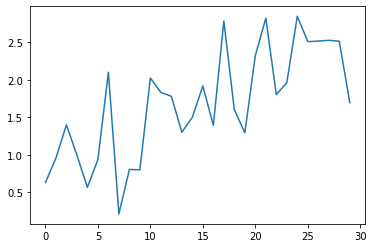

In [278]:
plt.plot(test_signal[:,0])

In [279]:
import statsmodels.api as sm
reg=sm.OLS(np.arange(30)[:,None],test_signal[:,0])
reg_res=reg.fit()
reg_res.rsquared

0.8786735917310461